In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Conv2D, GlobalMaxPooling1D, MaxPooling2D
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

sns.set()
current_palette = sns.color_palette('colorblind')

Using TensorFlow backend.


In [2]:
features = 20 #entspricht der Anzahl der Sensoren
timesteps = 22 # *0.05s --> definiert die Zeitspanne in der zeitliche Abhängigkeiten vom Netzwerk erlernt werden können
num_classes = 4 #Labelanzahl des Outputlayers
batchsize = 128
LSTM_size = 64 #ANzahl der LSTM-Zellen
epochen = 50


name = 'NN1_1'

#### Aufbau Model

In [3]:
model = Sequential()
#model.add(Conv1D(100,10, activation='relu', input_shape=(timesteps, features)))
#model.add(Conv1D(64,10, activation='relu'))
#model.add(MaxPooling1D(2))
model.add(LSTM(LSTM_size, dropout=0.3, recurrent_dropout=0.3 ,return_sequences=True, input_shape=(timesteps, features)))
model.add(Conv1D(64,1, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', #wird verwendet bei ont-hot-codierungen (p118 DL mit python und keras, francois chollet)
              optimizer='rmsprop',
              metrics=['accuracy'])

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 64)            21760     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            4160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 26,180
Trainable params: 26,180
Non-trainable params: 0
_________________________________________________________________


#### Trainingsdaten laden

In [5]:
x_train = np.load('4Label/x_train.npy')
x_val = np.load('4Label/x_val.npy')
y_train = np.load('4Label/y_k_train.npy')
y_val = np.load('4Label/y_k_val.npy')
x_test = np.load('4Label/x_test.npy')
y_test = np.load('4Label/y_k_test.npy')

In [6]:
y_train = y_train[:,21,]
y_val = y_val[:,21,]
y_test = y_test[:,21,]
#y_train = np.ndarray.reshape(y_train, (len(y_train),1,4))
#y_val = np.ndarray.reshape(y_val, (len(y_val),1,4))
#y_test = np.ndarray.reshape(y_test, (len(y_test),1,4))

In [7]:
y_train.shape

(5120, 4)

In [8]:
x_train.shape, y_train.shape

((5120, 22, 20), (5120, 4))

#### Model trainieren

In [9]:
model.fit(x_train, y_train,
          batch_size=batchsize , epochs=epochen, validation_data=(x_val, y_val))

Train on 5120 samples, validate on 1152 samples
Epoch 1/50
5120/5120 [==============================] - 2s 374us/step - loss: 0.7368 - acc: 0.7334 - val_loss: 0.3132 - val_acc: 0.8802
Epoch 2/50
5120/5120 [==============================] - 1s 199us/step - loss: 0.3080 - acc: 0.8904 - val_loss: 0.1870 - val_acc: 0.9306
Epoch 3/50
5120/5120 [==============================] - 1s 156us/step - loss: 0.2253 - acc: 0.9166 - val_loss: 0.1730 - val_acc: 0.9306
Epoch 4/50
5120/5120 [==============================] - 1s 162us/step - loss: 0.1799 - acc: 0.9311 - val_loss: 0.1443 - val_acc: 0.9410
Epoch 5/50
5120/5120 [==============================] - 1s 171us/step - loss: 0.1627 - acc: 0.9361 - val_loss: 0.1367 - val_acc: 0.9453
Epoch 6/50
5120/5120 [==============================] - 1s 159us/step - loss: 0.1481 - acc: 0.9389 - val_loss: 0.1235 - val_acc: 0.9497
Epoch 7/50
5120/5120 [==============================] - 1s 160us/step - loss: 0.1385 - acc: 0.9447 - val_loss: 0.1255 - val_acc: 0.9453


In [10]:
history_dict = model.history.history
#history_dict

#### Analysiere Trainingsergebnisse

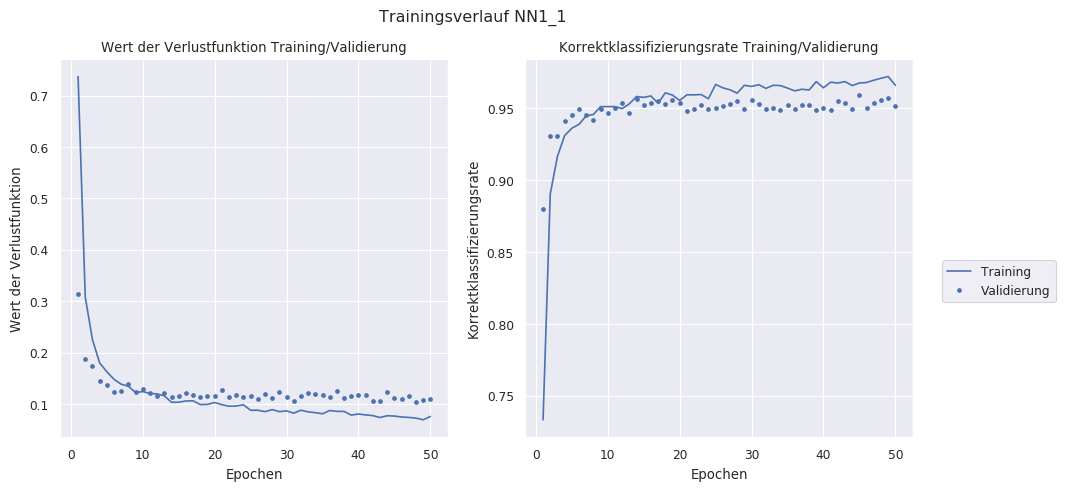

In [11]:
sns.set_context("paper")

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(11, 5), dpi=100, facecolor='w', edgecolor='k')
f.suptitle('Trainingsverlauf '+name)
ax1.plot(epochs, loss_values, 'b')
ax1.plot(epochs, val_loss_values, 'b.')
ax1.set_title('Wert der Verlustfunktion Training/Validierung')
ax1.set(xlabel='Epochen', ylabel='Wert der Verlustfunktion')

acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(loss_values)+1)

ax2.plot(epochs, acc, 'b', label='Training')
ax2.plot(epochs, val_acc, 'b.', label='Validierung')
ax2.set(title='Korrektklassifizierungsrate Training/Validierung',xlabel='Epochen',ylabel='Korrektklassifizierungsrate')
ax2.legend(bbox_to_anchor=(0.9, 0., 0.5, 0.5), borderaxespad=1)
f.subplots_adjust(wspace=0.2)
plt.show()

#### Anwendung des trainierten Models auf 'unbekannte' Trainingsdaten

In [12]:
predictions = model.predict(x_test,batch_size=batchsize)

In [13]:
predictions[0]

array([4.2247483e-01, 3.6016665e-02, 2.0721454e-04, 5.4130131e-01],
      dtype=float32)

In [14]:
'''a=[[0,0,0,0]]
c=[[0,0,0,0]]
for i in range(0,predictions.shape[0]):
    a[0] = predictions[i,0]
    c = np.concatenate((c,a), axis=0)
c = c[1:]
'''
test_out = np.zeros(len(predictions))
for i in range(0,len(predictions)-1):
    test_out[i] = np.argmax(predictions[i])

In [15]:
'''#Umstellung return_sequence = False
predictions = model.predict(x_val,batch_size=128)


b=[0]
for i in range(predictions.shape[0]):
    b = np.concatenate((b,[np.argmax(predictions[i])]), axis=0)


c=[0]
for i in range(predictions.shape[0]):
    c = np.concatenate((c,[np.argmax(y_test1[i])]), axis=0)'''

'#Umstellung return_sequence = False\npredictions = model.predict(x_val,batch_size=128)\n\n\nb=[0]\nfor i in range(predictions.shape[0]):\n    b = np.concatenate((b,[np.argmax(predictions[i])]), axis=0)\n\n\nc=[0]\nfor i in range(predictions.shape[0]):\n    c = np.concatenate((c,[np.argmax(y_test1[i])]), axis=0)'

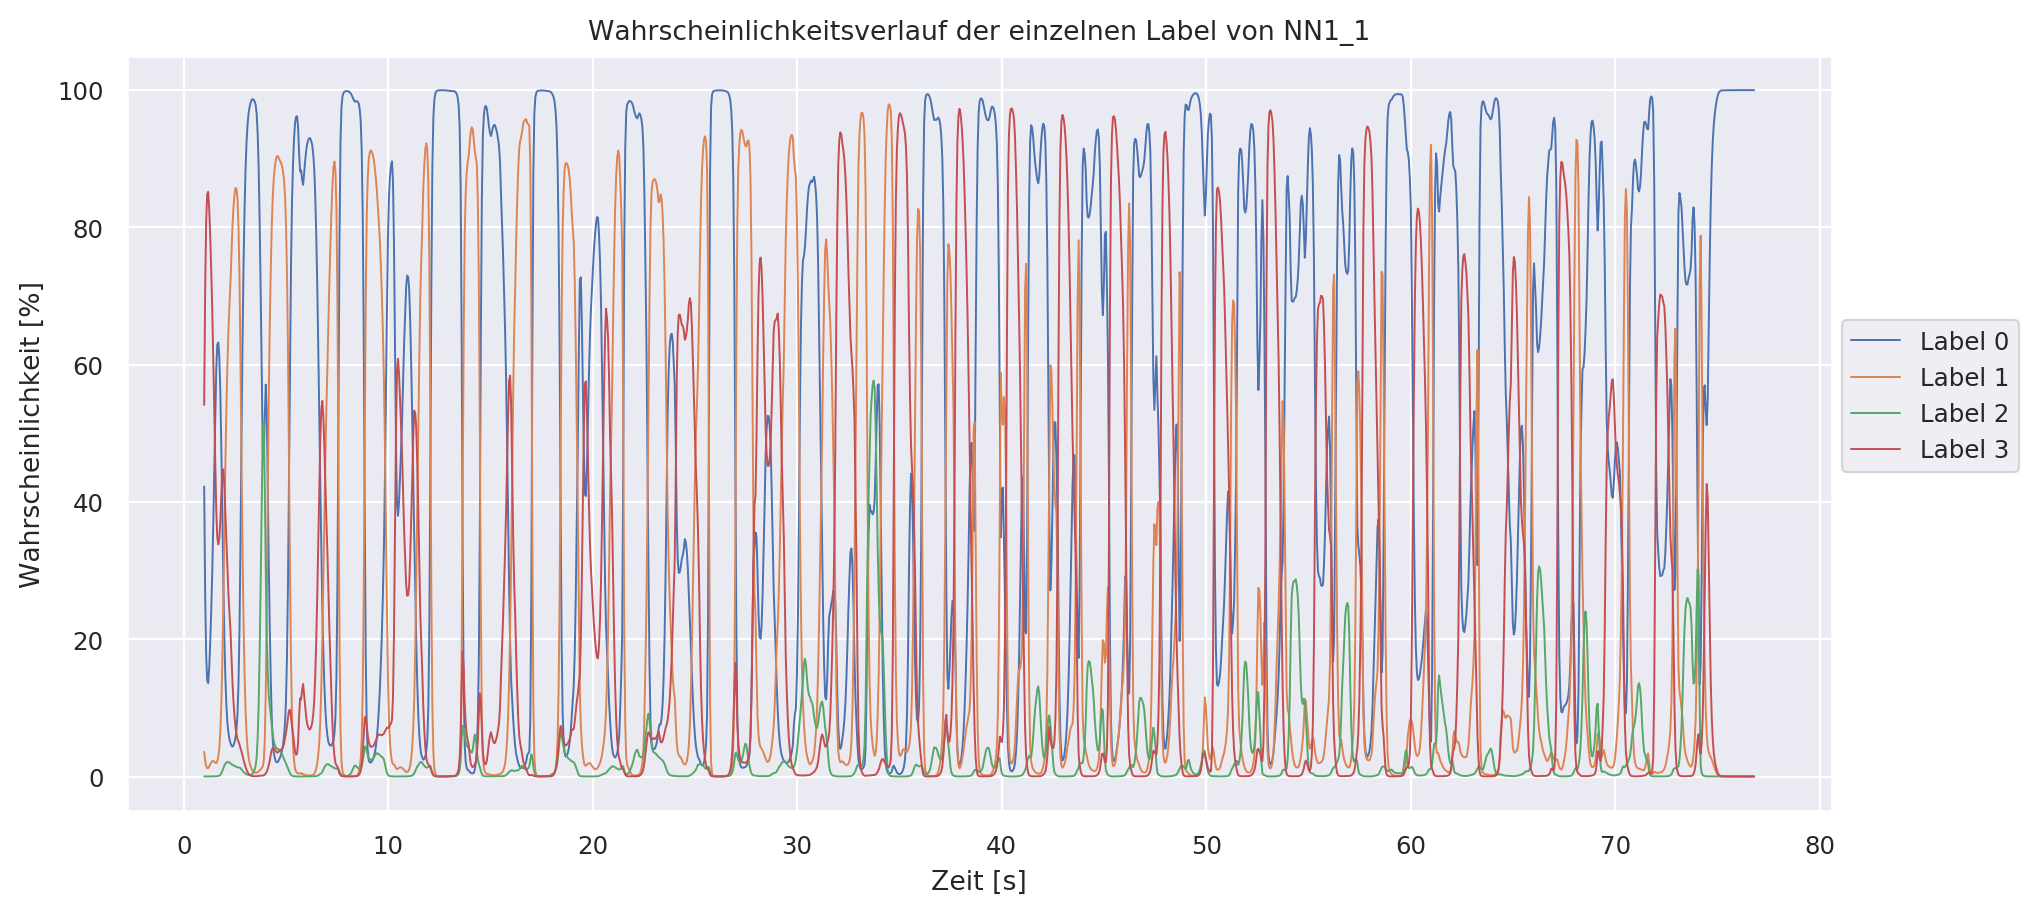

In [16]:
plt.figure(num=None, figsize=(11,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.linspace(1,len(predictions)*0.05,len(predictions)), predictions[:,0]*100, label='Label 0', linewidth=0.7)
plt.plot(np.linspace(1,len(predictions)*0.05,len(predictions)), predictions[:,1]*100, label='Label 1', linewidth=0.7)
plt.plot(np.linspace(1,len(predictions)*0.05,len(predictions)), predictions[:,2]*100, label='Label 2', linewidth=0.7)
plt.plot(np.linspace(1,len(predictions)*0.05,len(predictions)), predictions[:,3]*100, label='Label 3', linewidth=0.7)
#plt.yticks([0,50,100])
plt.title('Wahrscheinlichkeitsverlauf der einzelnen Label von '+name)
plt.xlabel('Zeit [s]')
plt.ylabel('Wahrscheinlichkeit [%]')
plt.legend(bbox_to_anchor=(0.61, 0.15, 0.5, 0.5), borderaxespad=0)
plt.show()

In [17]:
y_real = np.zeros(len(y_test))
for i in range(len(y_test)):
    y_real[i] = np.argmax(y_test[i])

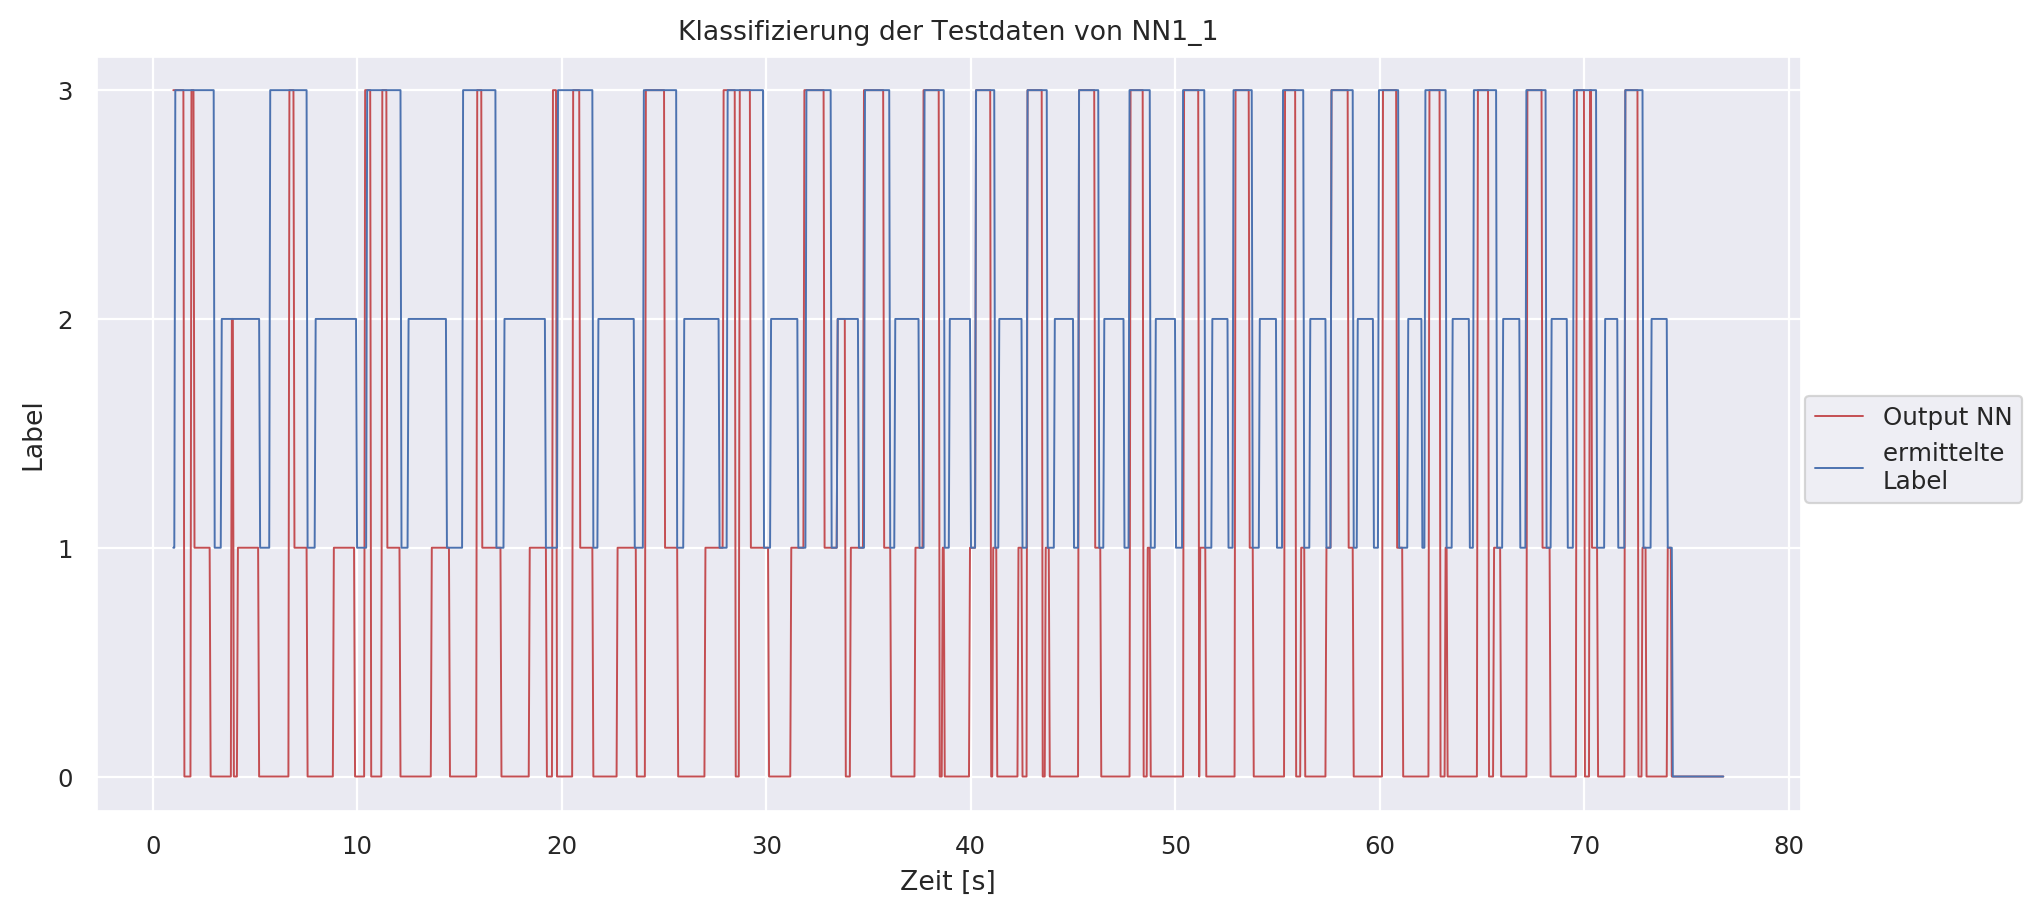

In [18]:
plt.figure(num=None, figsize=(11, 5), dpi=200, facecolor='w', edgecolor='k'),

plt.yticks([0,1,2,3])

plt.plot(np.linspace(1,len(test_out)*0.05,len(test_out)), test_out, 'r', label='Output NN',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(test_out)*0.05,len(test_out)), y_real, 'b', label='ermittelte \nLabel', linewidth=0.7, mew=0.1)
plt.title('Klassifizierung der Testdaten von '+name)
plt.xlabel('Zeit [s]')
plt.ylabel('Label')

plt.legend(bbox_to_anchor=(0.61, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=600, right=800)

plt.show()

## Zusammenfassung

In [19]:
# Nach welcher Epoche sollte das Training optimalerweise abgeschlossen werden?
# Vorgehen: einmal Netzwerk berechnen in 25 Epochen -> optimale Epochenanzahl anhand 'min_index_val_loss+1' ablesen und als Parameter oben angeben,
#           danach Netzwerk neu berechnen lassen.
min_index_val_loss, min_value_val_loss = min(enumerate(history_dict['val_loss']), key=operator.itemgetter(1))
max_index_val_acc, max_value_val_acc = max(enumerate(history_dict['val_acc']), key=operator.itemgetter(1))
print('Ergebnisse der Validierungsdaten:')
print('  opimale Epochenanzahl:                                   '+str(min_index_val_loss+1))
print('  minimaler Verlust:                                       '+str(min_value_val_loss))
print('  maximale Korrektklassifizierung der Validierungsdaten:   '+str(max_value_val_acc)+'\n')

if (max_index_val_acc != min_index_val_loss):
    print('Index optimalen Verlusts und optimaler Korrektklassifizierung nicht idetisch !!! max_index_val_acc bei Epoche '+str((max_index_val_acc)+1)+'\n\n')

print('Ergebnisse der Trainingdaten zur optimalen Epochenzahl:')
print('  Verlust:                     '+str(history_dict['loss'][min_index_val_loss]))
print('  Korrektklassifizierung:      '+str(history_dict['acc'][min_index_val_loss])+'\n\n')

gleiche_werte = np.sum(np.equal(test_out,y_real))
alle_testwerte = len(test_out)
print('Ergebnisse der Testdaten des trainierten neuronalen Netzes:')
print('  Anteil der Übereinstimmenden Werte: '+ str(gleiche_werte/alle_testwerte))
print('  Korrelationskoeffizient:            '+ str(np.corrcoef(test_out,y_real)[0,1]))

Ergebnisse der Validierungsdaten:
  opimale Epochenanzahl:                                   48
  minimaler Verlust:                                       0.10459800829186053
  maximale Korrektklassifizierung der Validierungsdaten:   0.9592013888888888

Index optimalen Verlusts und optimaler Korrektklassifizierung nicht idetisch !!! max_index_val_acc bei Epoche 45


Ergebnisse der Trainingdaten zur optimalen Epochenzahl:
  Verlust:                     0.07259949930012226
  Korrektklassifizierung:      0.9708984375


Ergebnisse der Testdaten des trainierten neuronalen Netzes:
  Anteil der Übereinstimmenden Werte: 0.30078125
  Korrelationskoeffizient:            0.5221179116657783


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 64)            21760     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            4160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 26,180
Trainable params: 26,180
Non-trainable params: 0
_________________________________________________________________


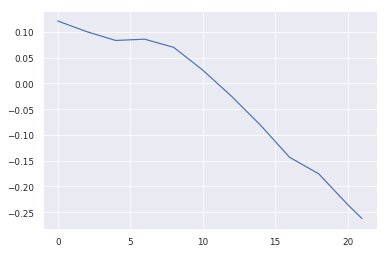

In [21]:
plt.plot(x_test[1,:,8])